# Forecasting retail turnover of household goods in the Australian economy

## Ian Dias
## Nov 2020

## Contents
### 1. Visualization of the Time-Series
### 2. Stationarity Checks
### 3. Predictors
#### 3.1 Naive Predictor
#### 3.2 AR Predictor
#### 3.3 Linear Regression - Seasonality Controls
#### 3.4 Holt Winters Smoothing
#### 3.5 Adding external variables
#### 3.6 Vector AutoRegression
### 4. Summary
### 5. Predictions


### Introduction

**I plan to forecast the monthly retail turnover of household goods in the Australian wide economy. The ABS has collected this data from May of 1982 and the last data available is until August 2020. The amount of household goods being traded is an important indication of an economy - as the goods range from electrical, to househod building and furniture. It appears that the more individuals are able to spend on these goods the seemingly more satisfaction and utility they achieve.**

**Due to the recent impacts of the COVID-19 pandemic, it would be of interest how this has affected the household goods industry. The Australian economy as a whole has reduced, but given that consumers are spending more time at home the impact it has had on this specific industry might not be completely obvious.**

**The data is accessed from: https://www.abs.gov.au/statistics/industry/retail-and-wholesale-trade/retail-trade-australia/latest-release**

### 1. Visualization of the time-series

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
def reset(data='850101.xls'):
    df = pd.read_excel(data,usecols=[0,2],sheet_name = 'Data1',skiprows='5')
    df = df[10:]
    df.set_index('Unnamed: 0', inplace=True)
    df.index.name = 'Dates'
    df.columns = ['Household goods']
    df.index = pd.to_datetime(df.index)
    return df
df = reset()

In [12]:
def plot(x,title=None,baseline=None, **kwargs):
    
    plt.plot(x, **kwargs)
    
    if baseline is not None:
        plt.plot(baseline, label='Baseline', alpha=0.5)
        plt.legend()
    
    plt.title(title)
    

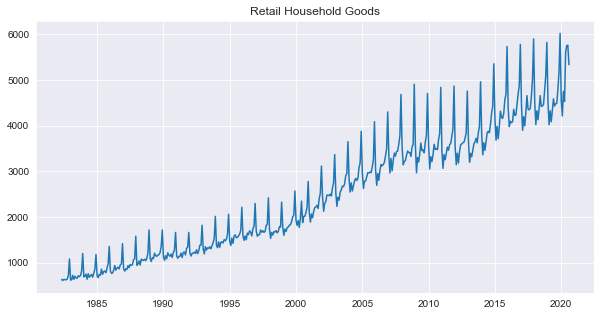

In [13]:
plot(df, title='Retail Household Goods')

**There seems to be both clear seasonality and and upwards trend to the data. The data will be isolated by year to identify the seasonality patterns and the impacts of the trend.**

### Visualizing the data and patterns

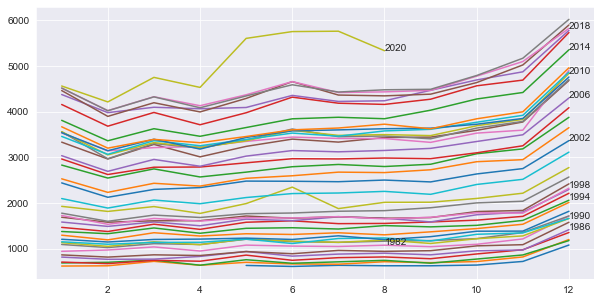

In [14]:
df['year'] = df.index.year 
df['month'] = df.index.month
years = df['year'].unique()
for i, y in enumerate(years):
    plt.plot('month', 'Household goods', data=df[df['year'] == y], label=y)
    if i % 4 == 0 or y == 2020:
        plt.text(df[df['year'] == y].shape[0], df[df['year'] == y]['Household goods'][-1:].values[0], y)


**Looking at the above graph, it appears that there is a definite upward tick for December and there could possibly be monthly or quarterly variation in the data.The mean also appears to be higher every year. There seems to be a significant increase in spending in 2020 starting from February and going on until the last value of October. This is most likely due to the COVID-19 virus that is impacting the world and began its Australian penetration in March. As more individuals are under lockdown they are staying home longer and this may increase the quantity of household goods they would typically require.**

### 2. Stationarity checks

In [15]:
df = reset()

In [16]:
from statsmodels.tsa.stattools import adfuller
first_diff = df.diff()
def dickey_fuller(x):
    '''Dickey-fuller test to check for stationarity'''
    result = adfuller(x)
    print('ADF Test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('The critical values are: {}' .format(result[4]))
    for key,value in result[4].items():
        if value > result[0]:
            print('There is a unit root present and the null hypothesis is rejected. The series is stationary.')
            return
    print('The null hypothesis is failed to be rejected. The series is not stationary.')
dickey_fuller(df)

ADF Test statistic: 1.572934
p-value: 0.997774
The critical values are: {'1%': -3.4451307246616514, '5%': -2.86805689169311, '10%': -2.570241263729327}
The null hypothesis is failed to be rejected. The series is not stationary.


**As the series is not stationary, the first difference will be taken to remove the impact of the trend.**

In [17]:
dickey_fuller(df.diff().dropna())

ADF Test statistic: -2.314816
p-value: 0.167234
The critical values are: {'1%': -3.4451307246616514, '5%': -2.86805689169311, '10%': -2.570241263729327}
The null hypothesis is failed to be rejected. The series is not stationary.


**Even after the first difference, the series is not stationarity. The log will first be taken, and then the first difference.**

In [18]:
np_df = np.array(df.dropna(), dtype='float').squeeze()
log_df = np.log(np_df)
log_diff_df = np.diff(log_df)
dickey_fuller(log_diff_df)

ADF Test statistic: -3.748849
p-value: 0.003476
The critical values are: {'1%': -3.4452655826028318, '5%': -2.868116205869215, '10%': -2.570272878944473}
There is a unit root present and the null hypothesis is rejected. The series is stationary.


**This gives a unit root and the series is stationary. Taking the log helps stablise the variance and differences help stabilize the mean.**

Text(0.5, 1.0, 'First Difference of the Log of Household Goods')

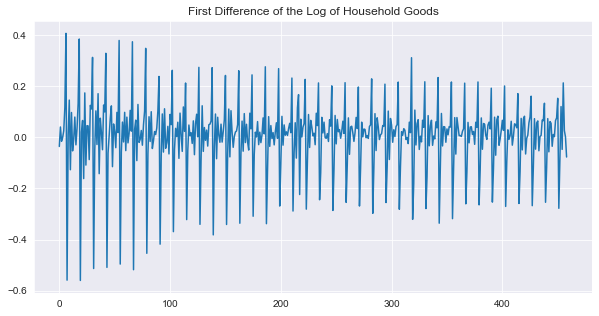

In [19]:
plt.plot(log_diff_df)
plt.title('First Difference of the Log of Household Goods')

Correlation functions will be used to determine the appropriate lag length.

In [20]:
def acf(x):
    '''Plotting the correlation of lag k with lag 0'''
    N = x.shape[0]
    ac = x-x.mean()

    lag0 = np.dot(ac, ac)
    lagk = np.correlate(ac, ac, mode='full')[N-1:]
    r = lagk/lag0

    return r

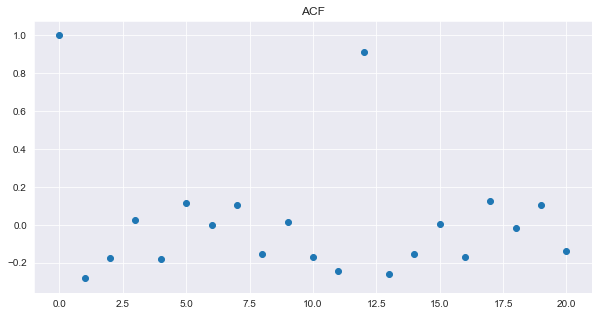

In [21]:
plt.title('ACF')
lags = 20
plt.scatter(x = range(0,lags+1), y=acf(log_diff_df)[:lags+1])

**Using acf given by statsmodels we get the following prettier graph:**

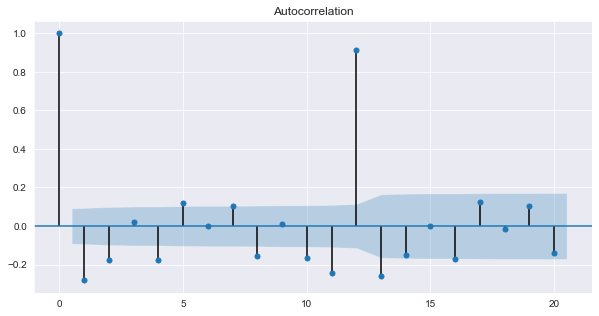

In [22]:
fig, axs = plt.subplots()
plot_acf(log_diff_df, ax=axs, lags=20)
plt.show()

**From the ACF above, lags 5, 12 have significant correlation with the current value and as well will be included in any further lagged process. There doesn't seem to be a geometric decay (only for past values of itself) and so it make indicate an MA process.**

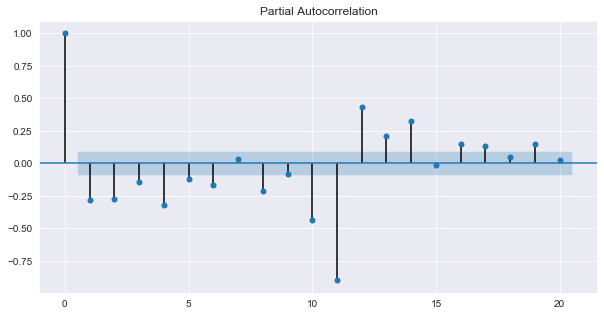

In [23]:
plot_pacf(log_diff_df, lags=20)
plt.show()

**If the series was an MA process, there would be a geometric decay in the PACF.**

In [24]:
#Converting df into a log and first difference transformation
df = reset()
df = df[1:]
df['log'] = log_diff_df
df = df.drop('Household goods',axis=1)
df = df.rename(columns={'log':'Household goods'})

### 3. Predictors

#### Evaluating Predictors

**The Mean Squared Forecast Error (MSFE) will be used to evaluate the predictors**

$ MSFE = \frac{1}{T-h-T0+1} \sum_{t=T0}^{T-h}(y_{t+h}-y_{pred t+h})^2$

### 3.1 - The benchmark: Naive Predictor

**The naive predictor used will have the following model specification: $y_t$ = $y_{t-1}$ and will be the baseline for any future model comparisons**

'The MSFE of this Naive Predictor is 0.049694'

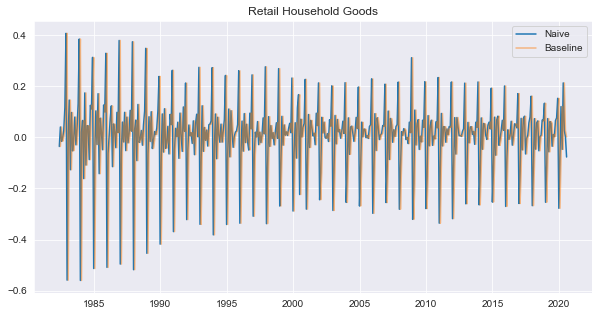

In [25]:
plot(df, label = 'Naive',baseline=df.shift(1), title='Retail Household Goods')

def MSFE_base(yhat, model, h=1, df=df, printf=True):
    MSFE = np.mean(np.square(yhat - df['Household goods'][h:]))
    if printf: 
        return 'The MSFE of this {} is {:2f}'.format(model, MSFE)
    else:
        return MSFE

MSFE_base(df.shift(1)['Household goods'], 'Naive Predictor')

In [26]:
msfe_naive = MSFE_base(df.shift(1)['Household goods'], model = 'naive',printf=False)

### 3.2 - AR(5, 12) Predictor

**As established in the ACF and PACF above, lags 5 and 12 will be used within an AR model.**

$ y_t = \beta_1y_{t-5} + \beta_2y_{t-12} + \epsilon_t$

In [151]:
df = reset()
df = df[1:]
df['log'] = log_diff_df
df = df.drop('Household goods',axis=1)
df = df.rename(columns={'log':'Household goods'})

In [152]:
#AR model

ytminus5 = df.shift(5)
ytminus12 = df.shift(12)
ytminus24 = df.shift(24)

df = df.join(ytminus5, rsuffix='yt-5')
df = df.join(ytminus12, rsuffix='yt-12')
df = df.dropna()
y = df['Household goods']
X = df.drop('Household goods', axis=1)

In [153]:
def MSFE(X, y, T0, h, plot=False, model=None):
    T = len(y)
    syhat = []
    for i in range(T0, T-h):
        temp_y = y[:i]
        temp_X = X[:i]
        temp_X = np.array(temp_X, dtype='float')
        beta_hat = (np.linalg.inv((temp_X.T@temp_X)) @ temp_X.T@temp_y)
        y_hat2 = temp_X @ beta_hat
        syhat.append(y_hat2[-1])
    if plot:
        return syhat

    return np.mean(np.square(y[T0+h:]-syhat))

In [154]:
def dummies(quarter = False, month = False):
    X = df.reset_index()
    if quarter:
        X['Dates'] = X['Dates'].dt.quarter
    if month:
        X['Dates'] = X['Dates'].dt.month

    y = X['Household goods']
    X = X.drop('Household goods', axis=1)
    X = pd.get_dummies(X['Dates'])
    X.reset_index(inplace=True)
    return X

def testing(X, T0=50, h=1, df = df):
    syhat = []
    for t in range(T0, len(df)-h):
        y = np.array(df['Household goods'][1:t])
        xt = X[1:t]
        beta_hat = np.linalg.inv((xt.T@xt)) @ xt.T@y
        #Now need a y_hat of t+h
        y_hat = X.iloc[t+h]@np.array(beta_hat)
        syhat.append(y_hat)
    return syhat

def adding_index(df, yhat, T0=50, h=1):
    df = df.reset_index()
    df = df.join(pd.DataFrame(yhat, index=range(T0+h,len(df))))
    df.set_index(df['Dates'], inplace=True)
    df = df.rename(columns={0:'yhat'})
    return df

def MSFE_new(syhat, model, T0=50, h=1):
    syhat = np.array(syhat)
    ytph = df['Household goods'][T0+h]
    msfe = np.mean(np.square(ytph-syhat))
    return 'The MSFE of {} is {}'.format(model, msfe)

In [155]:
AR = MSFE(X, y, 50, 1, plot=True)

In [156]:
df_new = adding_index(df, AR)
df_new = df_new.dropna()

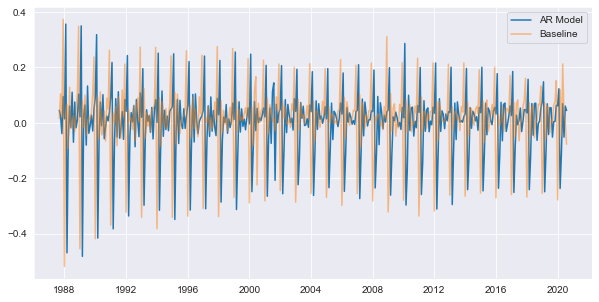

In [157]:
plot(df_new['yhat'], baseline=df_new['Household goods'], label='AR Model')

In [158]:
model = 'Auto Regressive Model'
print('The MSFE of this {} is {:2f}'.format(model, MSFE(X,y,50,1)))

The MSFE of this Auto Regressive Model is 0.036034


In [159]:
msfe_ar = MSFE(X,y,50,1)

### 3.3 Linear Regression - Seasonality Controls

**Two model specifications will be used, one to act as a dummy for yearly quarters and the other for the months.**

$ S_1: y_t = a_1 + a_1t + \sum_{i=1}^{4}\alpha_iD_{it} + \epsilon_t $

$ S_2: y_t = a_1t + \sum_{i=1}^{12}\beta_iM_{it}+\epsilon_t $

$S_1$: This includes a trend - $t$, and a dummy for all quarters $Di$, where $i$ $\epsilon$ [1,4]

$S_2$: This includes a trend $t$, and a dummy for all months of the year - $M_i$, where $i$ $\epsilon$ [1,12]

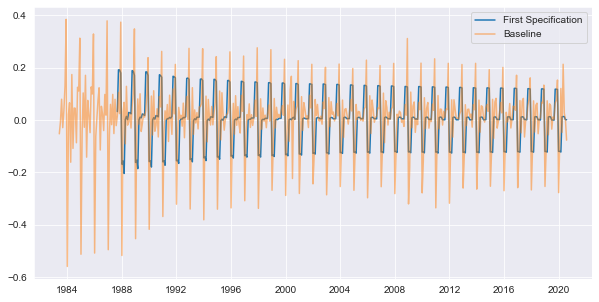

In [160]:
X_2 = dummies(quarter=True, month=False)
syhat_s2 = testing(X_2)
plot(adding_index(df, syhat_s2)['yhat'], baseline=df['Household goods'], label='First Specification')

In [161]:
MSFE_base(syhat_s2, 'First Specification',df=df[50:])

'The MSFE of this First Specification is 0.010590'

In [162]:
msfe_s1 = MSFE_base(syhat_s2, 'frs', df = df[50:],printf=False)

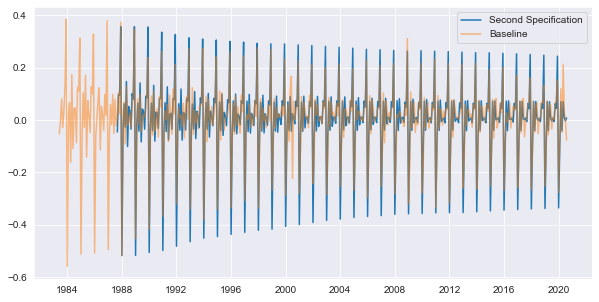

In [163]:
X_4 = dummies(quarter=False, month=True)
syhat_s4 = testing(X_4)
plot(adding_index(df, syhat_s4)['yhat'], baseline=df['Household goods'], label='Second Specification')

In [164]:
MSFE_base(syhat_s4, 'Second Specification',df=df[50:])

'The MSFE of this Second Specification is 0.002556'

In [165]:
msfe_s2 = MSFE_base(syhat_s4, 'frs', df = df[50:],printf=False)

### 3.4 Holt Winters Smoothing

In [166]:
def HWS(T0, s, alpha, beta, gamma, h, T = len(y)):
    syhat = []
    S = np.zeros((1,T-h))[0]
    L = np.mean(y[1:s])
    b = 0
    S[1:s] = y[1:s] - L
    
    for t in range(s+1, T-h):
        newL = alpha * (y[t] - S[t-s]) + (1-alpha) * (L+b)
        newb = beta * (newL-L) + (1-beta)*b

        S[t] = gamma * (y[t] - newL) + (1-gamma)*S[t-s]
        yhat = newL + h*newb + S[t+h-s]
        L = newL
        b = newb
        if t >= T0:
            syhat.append(yhat)
    return syhat

In [167]:
y = df['Household goods']

In [168]:
hws_syhat = HWS(50, 4, 0.4, 0.4, 0.4, 1)
#df_new = adding_index(df, hws_syhat, T0=64)
df_new = adding_index(df, hws_syhat, T0=50)
df_new = df_new.dropna()
df_new = df_new.drop('Dates', axis=1)

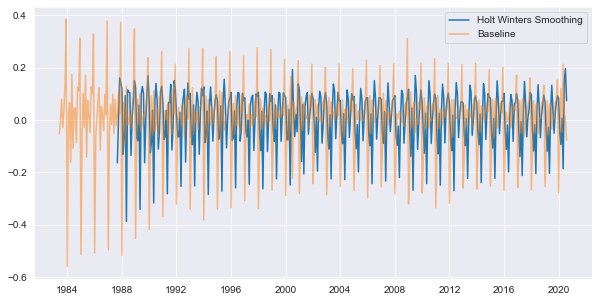

In [169]:
plot(df_new['yhat'], baseline=df['Household goods'], label='Holt Winters Smoothing')

In [170]:
MSFE_base(df_new['yhat'], 'Holt Winters Smoothing',df=df)

'The MSFE of this Holt Winters Smoothing is 0.031991'

In [171]:
def optim_point(T0):
    alpha = np.arange(0,1,0.1)
    h = 1
    beta = gamma = alpha
    all_values = []
    index = []
    temp = []
    for i in alpha:
        for j in beta:
            for k in gamma:
                syhat = HWS(50, 4, i, j, k, h)
                temp = np.mean(np.square(syhat - df['Household goods'][T0+h:]))
                index.append((i,j,k))
                all_values.append(temp)
    opt_point = np.array(index)[all_values == np.min(all_values)]
    return opt_point

In [172]:
#optimal = optim_point(64)
optimal = optim_point(50)
print('The optimal parameters for the Holt Winter Smoothing are: \n{}'.format(optimal))

The optimal parameters for the Holt Winter Smoothing are: 
[[0.  0.  0.1]
 [0.  0.1 0.1]
 [0.  0.2 0.1]
 [0.  0.3 0.1]
 [0.  0.4 0.1]
 [0.  0.5 0.1]
 [0.  0.6 0.1]
 [0.  0.7 0.1]
 [0.  0.8 0.1]
 [0.  0.9 0.1]]


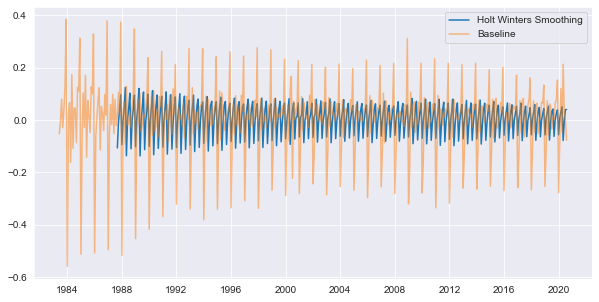

In [173]:
hws_syhat = HWS(T0=50, s=4, alpha=0, beta=0, gamma=0.1, h=1)
df_new = adding_index(df, hws_syhat, T0=50)
df_new = df_new.dropna()
plot(df_new['yhat'], baseline=df['Household goods'], label='Holt Winters Smoothing')

In [174]:
msfe_hw = MSFE_base(df_new['yhat'], 'Holt Winters Smoothing',df=df, printf=False)
MSFE_base(df_new['yhat'], 'Holt Winters Optimized Smoothing',df=df)

'The MSFE of this Holt Winters Optimized Smoothing is 0.014540'

### 3.5 Adding external variables

**The Australian National Accounts: National Income, Expenditure and Product dataset was downloaded from the ABS through the following link: https://www.abs.gov.au/statistics/economy/national-accounts/australian-national-accounts-national-income-expenditure-and-product/latest-release#data-download**

**It gives information of a broader economic glow in Australia. As this heavily relate to the amount of Household Goods being bought, it was thought that adding these as regressors would aid any future predictions of Household Goods. However, there are 108 potential regressors within this new dataset. Principal Component Analysis (PCA) along with relevant Economic knowledge will be used to determine which regressors to add**

In [175]:
df_nat = pd.read_excel('National_accounts.xls',sheet_name = 'Data1', index_col=0, prase_dates=True)
Xs = df_nat[10:].dropna(axis=1)
yXs = Xs.join(df).dropna()

In [52]:
new = (yXs).drop('Household goods', axis=1)
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
sc = StandardScaler()
X_std = sc.fit_transform(new)

In [53]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_std)

In [54]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = new.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

Through the above PCA analysis, the most relevant columns are the ones below.

In [55]:
most_important_names

['GDP per capita: Current prices ;.2',
 'RGDI',
 'Real gross domestic income: Chain volume measures - Percentage changes ;.1',
 'Household saving ratio: Ratio ;.2',
 'Terms of trade: Index - Percentage changes ;.1',
 'Household goodsyt-12']

#### Using PCA on the new dataset, the most important variables are: RGDI, terms of trade and household saving ratio. These will be added into future models

**The new timeseries have values collected only every 3 months while household goods have values collected every month. Instead of reducing the number of household good observations to match the new timeseries, it was decided to instead interpolate the new timeseries datasets to fill in the gaps. The method used was a simple linear method as it was determined the underlying functions of RGDI, Terms of Trade and Household saving ratio were not too ambitious.**

In [56]:
reg = yXs[['RGDI', 'Terms of trade: Index - Percentage changes ;.1', 'Household saving ratio: Ratio ;.2']]

In [57]:
y = df['Household goods']

In [58]:
all_df = df.join(reg)
all_df = all_df.apply(pd.to_numeric)
all_df = all_df.interpolate(method='linear', limit_direction='forward', axis=0)[1:]

In [59]:
all_df = all_df.rename(columns={'Terms of trade: Index - Percentage changes ;.1':'Terms of trade', 
                                'Household saving ratio: Ratio ;.2':'Savings ratio'})
new_X = all_df[['RGDI','Terms of trade','Savings ratio']]
new_y = pd.DataFrame(all_df['Household goods'])

Equation 1: $ y_t = \beta_0 + \beta_1RGDI + \beta_2TOT + \beta_3Savings $

In [60]:
var_syhat = testing(new_X, df=new_y)

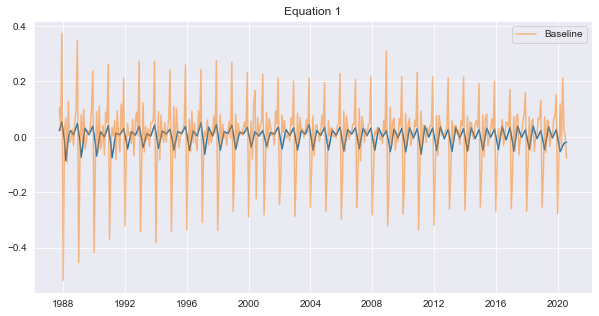

In [181]:
plot(adding_index(all_df, var_syhat)['yhat'], title='Equation 1',baseline=(all_df['Household goods'][51:]))

Equation 2: $ y_t = y_{t-1} \beta_0 + \beta_1RGDI + \beta_2TOT + \beta_3Savings $

In [62]:
AR_X = new_X.join(y.shift(1))
AR_syhat = testing(AR_X, df=new_y)

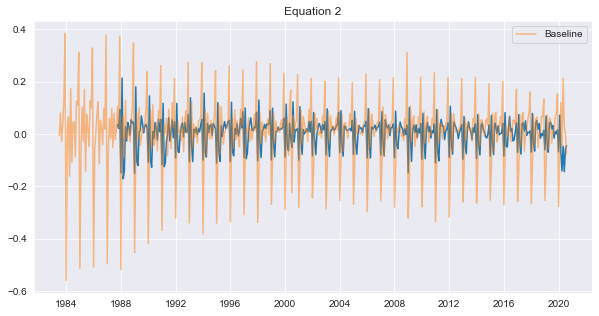

In [182]:
plot(adding_index(all_df, AR_syhat)['yhat'], title='Equation 2', baseline=(all_df['Household goods']))

In [64]:
msfe_ar1 = MSFE_base(AR_syhat, 'Linear Regression',df=df[51:], printf=False)

In [65]:
MSFE_base(AR_syhat, 'Linear Regression',df=df[51:])

'The MSFE of this Linear Regression is 0.013523'

Equation 3: $ y_t =  \alpha_0 y_{t-1} + \alpha_1RGDI + \alpha_2TOT + \alpha_3Savings  + a_1t + \sum_{i=1}^{12} \beta_iM_{it} + \epsilon_t$


In [184]:
X_4 = X_4[1:].set_index(all_df.index)

In [185]:
new_X_4 = all_df.join(X_4)
new_X_4[['Household goods', 'Household goodsyt-5', 'Household goodsyt-12']] = new_X_4[['Household goods', 'Household goodsyt-5', 'Household goodsyt-12']].shift(1)
new_X_4 = new_X_4[1:]

In [186]:
new_X_4_syhat = testing(new_X_4, df=new_y[1:])
len(new_X_4_syhat)

394

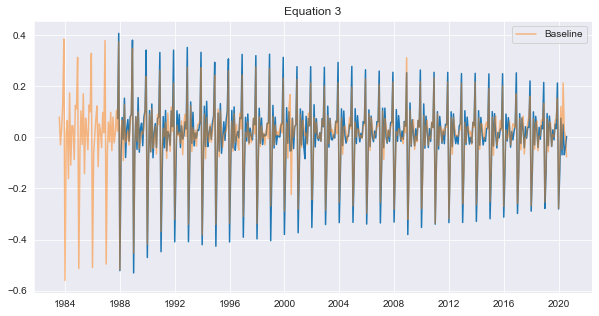

In [187]:
plot(adding_index(all_df[1:], new_X_4_syhat)['yhat'], title = 'Equation 3', baseline=(all_df['Household goods'][1:]))

In [188]:
msfe_ar2 = MSFE_base(new_X_4_syhat, 'Equation 3',df=df[52:],printf=False)
MSFE_base(new_X_4_syhat, 'Equation 3',df=df[52:])

'The MSFE of this Equation 3 is 0.001929'

### 3.6 Vector AutoRegression

In [71]:
dickey_fuller(all_df['RGDI'])

ADF Test statistic: -4.014061
p-value: 0.001339
The critical values are: {'1%': -3.445685337552546, '5%': -2.868300808913956, '10%': -2.570371276889389}
There is a unit root present and the null hypothesis is rejected. The series is stationary.


In [72]:
dickey_fuller(all_df['Terms of trade'])

ADF Test statistic: -3.707819
p-value: 0.004005
The critical values are: {'1%': -3.445757604526768, '5%': -2.8683325885102855, '10%': -2.5703882165206853}
There is a unit root present and the null hypothesis is rejected. The series is stationary.


In [73]:
dickey_fuller(all_df['Savings ratio'])

ADF Test statistic: -2.778849
p-value: 0.061359
The critical values are: {'1%': -3.445685337552546, '5%': -2.868300808913956, '10%': -2.570371276889389}
There is a unit root present and the null hypothesis is rejected. The series is stationary.


**All relevant variables [RGDI, Terms of Trade, Savings ratio] are stationary.**

$ y_t = b + B_1y_{t-1} + ... + B_py_{t-p} + \epsilon_t$

where $b$ is an n x 1 vector of intercepts and $B_i$ is an n x n coefficient matrix

$$ \begin{bmatrix}y_{1,t}\\ y_{2,t} \\ ... \\ y_{p,t} \end{bmatrix} = \begin{bmatrix}b_1 \\ b_2 \\ ... \\ b_p \end{bmatrix}
+ \begin {bmatrix}B_{11,1} & B_{12,2} & B_{13,3} & B_{14,4} \\ B_{21,2} & B_{22,2} & B_{23,3} & B_{24, 4}\\ ... & ... & ... & ... \\ B_{p1,p} & B_{p2,p} & B_{p3,p}  & B_{p4,p}\end{bmatrix} \begin{bmatrix}y_{1,t-1}\\ y_{2,t-2} \\ ... \\ y_{p,t-p} \end{bmatrix} + \begin{bmatrix}\epsilon_{1,t}\\ \epsilon_{2,t-2} \\ ... \\ \epsilon_{p,p} \end{bmatrix}
$$

Rewrite our model as $ y = X\beta + \epsilon $, where $\epsilon ~ N(0,\Sigma)$

$ \beta = (X'X)^{-1}X'y $

$ \Sigma = 1/T(y_t - X_t\beta)(y_t - X_t\beta)' $

In [190]:
X = all_df[['Household goods', 'RGDI', 'Terms of trade', 'Savings ratio']]
X['Household goods'] = X['Household goods'].shift(1)
X = X.rename(columns={'Household goods': 'Household goods -1'})
X = X[1:]
y = all_df['Household goods'][1:]

C:\Users\idias\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [191]:
Betahat = np.linalg.inv(X.T@X) @ X.T@y
Betahat = np.array(Betahat).reshape(-1,1)

In [192]:
T = len(y)
T0 = 50
yhatVAR = []
for t in range(T0, T):
    yt = y[:t]
    Xt = X[:t]
    beta = np.array(np.linalg.inv(X.T@X) @ X.T@y).reshape(-1,4)
    yt = np.array(yt)
    yt = yt.reshape(-1,1)
    all_yt = np.concatenate((yt[:t-3], yt[1:t-2], yt[2:t-1], yt[3:t]), axis=1, ).reshape(-1,4)
    yhatVAR.append((beta @ all_yt.T)[-1][-1])

In [193]:
msfe_var = np.mean(np.square(y[T0+1:] - yhatVAR[:-1]))
print('The MSFE of the VAR is: ', msfe_var)

The MSFE of the VAR is:  0.02063982035930446


In [194]:
y = pd.DataFrame(y)
y.loc['2020-09-01 00:00:00'] = yhatVAR[-1]

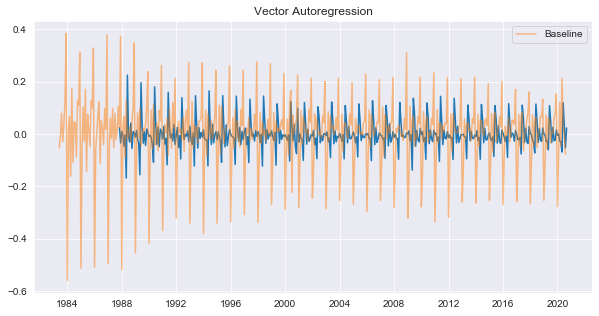

In [195]:
yhatVARindex = adding_index(df=y, yhat = yhatVAR)['yhat']
plot(yhatVARindex, baseline=df['Household goods'], title='Vector Autoregression')

### 4. Summary

In [198]:
print('''Summary of MSFEs from all the models:\n\nThe Naive model: {:3f}\nThe AR(5,12) model: {:3f}\nThe Holt winters model: {:3f}
The AR and external variable (1) model: {:3f}\nThe AR and extgenal variable (2) model: {:3f}
The VAR model: {:3f}'''.format(msfe_naive, msfe_ar, msfe_hw, msfe_ar1, msfe_ar2, msfe_var))

Summary of MSFEs from all the models:

The Naive model: 0.049694
The AR(5,12) model: 0.036034
The Holt winters model: 0.014540
The AR and external variable (1) model: 0.013523
The AR and extgenal variable (2) model: 0.001929
The VAR model: 0.020640


The model with the lowest MSFE was the following:

$ y_t =  \alpha_0 y_{t-1} + \alpha_1RGDI + \alpha_2TOT + \alpha_3Savings  + a_1t + \sum_{i=1}^{12} \beta_iM_{it} + \epsilon_t$

### 5. Predictions

In [211]:
def testing(X, T0=50, h=1, df = df):
    syhat = []
    for t in range(T0, len(df)-h):
        y = np.array(df['Household goods'][1:t])
        xt = X[1:t]
        beta_hat = np.linalg.inv((xt.T@xt)) @ xt.T@y
        #Now need a y_hat of t+h
        y_hat = X.iloc[t+h]@np.array(beta_hat)
        syhat.append(y_hat)
    return syhat

In [212]:
new_X_4_syhat = testing(new_X_4, df=new_y[1:], h=1)

In [213]:
msfe_ar2 = MSFE_base(new_X_4_syhat, 'model',df=df[52:],printf=False)
MSFE_base(new_X_4_syhat, 'model',df=df[52:])

'The MSFE of this model is 0.001929'

In [214]:
date_index = ['2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00']
h = 4
new_X_4_syhat = testing(new_X_4, df=new_y[1:], h=h)
new_x = adding_index(all_df[8:], new_X_4_syhat[:-h])
MSFE_base(new_X_4_syhat[:-h], 'model for h=4',df=df[59:]) #MSFE for when h = 4

'The MSFE of this model for h=4 is 0.043030'

### Point forecasts

In [215]:
h=4
forecast = pd.DataFrame(new_X_4_syhat[-h:],index=date_index[:h])
forecast = forecast.rename(columns={0:'yhat'})
forecast = new_x.append(forecast)
forecast.index = pd.to_datetime(forecast.index)

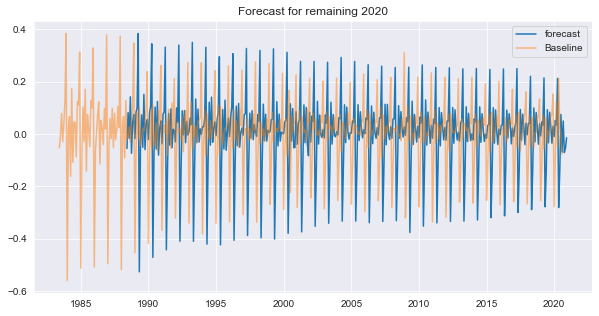

In [216]:
plot(forecast['yhat'], title='Forecast for remaining 2020', baseline=df['Household goods'], label='forecast')

**Forecasting 4 periods in the future for the remaining months of 2020 yields the following:**

In [217]:
forecast[-h:]['yhat']

2020-09-01    0.049552
2020-10-01   -0.071381
2020-11-01   -0.054260
2020-12-01   -0.014781
Name: yhat, dtype: float64

**Now we need to convert it back to the original data values**

In [218]:
orig = reset() #This is the original dataset i.e. df['Household goods']
#Need to make sure the indexes match the predicted yhat, had to use orig[18:]
#Forecast['yhat'] is the predicted yhat. Make sure the indexes are correct
real_forecast = np.exp(forecast['yhat']).cumsum() + orig[18:].set_index(forecast.index)['Household goods']

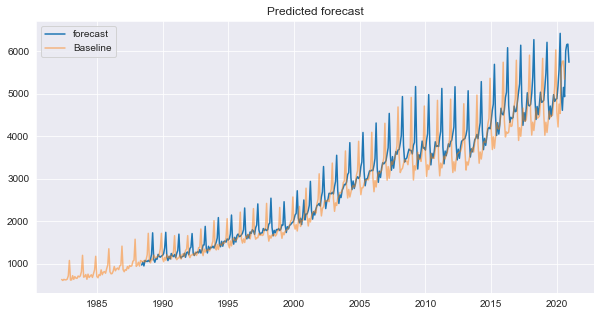

In [219]:
plot(real_forecast, title = 'Predicted forecast', label='forecast',baseline=orig)

**The forecast with the original values for the remaining months of 2020**

In [92]:
real_forecast[-h:]

2020-09-01    6001.99
2020-10-01    6151.92
2020-11-01    6161.16
2020-12-01    5734.15
dtype: object

### Density Forecasts

In [93]:
k = 6
orig = reset()
var = 1/(len(orig)-k) * sum(np.square((real_forecast.dropna() - orig[69:]['Household goods']).dropna()))

In [94]:
real_density = []
for i in real_forecast[-h:]:
    real_density.append((i + 1.96*np.sqrt(var), i - 1.96*np.sqrt(var)))

In [95]:
print('''On 2020-09-01, there is a 95% probability of the data lying between {} and {}
On 2020-10-01, there is a 95% probability of the data lying between {} and {}
On 2020-11-01, there is a 95% probability of the data lying between {} and {}
On 2020-12-01, there is a 95% probability of the data lying between {} and {}'''
      .format(real_density[0][1],real_density[0][0], real_density[1][1],real_density[1][0],
             real_density[2][1],real_density[2][0], real_density[3][1],real_density[3][0]))

On 2020-09-01, there is a 95% probability of the data lying between 4971.335179432508 and 7032.635330243136
On 2020-10-01, there is a 95% probability of the data lying between 5121.266286546312 and 7182.566437356938
On 2020-11-01, there is a 95% probability of the data lying between 5130.513471890277 and 7191.813622700904
On 2020-12-01, there is a 95% probability of the data lying between 4703.498799674406 and 6764.798950485032


**The following is a one-step ahead forecast, instead of a 4-step forecast for the entire year.**

### One-step ahead forecast for evaluation

In [96]:
#One step ahead forecast
orig = reset()
h=1
forecast = pd.DataFrame(new_X_4_syhat[-h:],index=date_index[:h])
forecast = forecast.rename(columns={0:'yhat'})
forecast = new_x.append(forecast)
forecast.index = pd.to_datetime(forecast.index)

orig = reset()
real_forecast = np.exp(forecast['yhat']).cumsum() + orig[21:].set_index(forecast.index)['Household goods']
real_forecast[-h:]

2020-09-01    5731.22
dtype: object

In [97]:
k = 6
orig = reset()
var = 1/(len(orig)-k) * sum(np.square((real_forecast.dropna() - orig[69:]['Household goods']).dropna()))

real_density = []
for i in real_forecast[-h:]:
    real_density.append((i + 1.96*np.sqrt(var), i - 1.96*np.sqrt(var)))
    
print('On 2020-09-01, there is a 95% probability of the data lying between {} and {}'
      .format(real_density[0][1],real_density[0][0]))

On 2020-09-01, there is a 95% probability of the data lying between 4916.835561142746 and 6545.604004096039


In [9]:
reset('new_data.xls')

,Household goods
Dates,
1982-05-01,629.6
1982-06-01,607.4
1982-07-01,632.4
1982-08-01,622.6
1982-09-01,622
...,...
2020-05-01,5607.6
2020-06-01,5756.6
2020-07-01,5764.9
